##Import various python functions and modules that we need.

In [8]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [9]:
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


##Import R libraries we'll use.

In [10]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(dplyr)
library(plyr)
library(RColorBrewer)
library(stats)
library(stringr)

##Import data into R. Prune to relevant samples (Chazy). Get rid of OTUs not observed in at least 25% of samples)

In [22]:
%%R 
physeq = import_biom("data/otu_table_JSON_wtax.biom", "data/otusn_JSON.tree")
print(physeq)
sample.data = import_qiime_sample_data("data/JSON_mapping_file.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
print(physeq)
physeq = prune_samples((physeq.md$Treatment %in% c("NTR","NTH", "PTH", "PTR", "PAS")), physeq)
physeq.md = sample_data(physeq)
physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) / length(x) > (0.25), TRUE)
print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9756 taxa and 82 samples ]
tax_table()   Taxonomy Table:    [ 9756 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9756 tips and 9755 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9756 taxa and 82 samples ]
sample_data() Sample Data:       [ 82 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9756 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9756 tips and 9755 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3588 taxa and 66 samples ]
sample_data() Sample Data:       [ 66 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 3588 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3588 tips and 3587 internal nodes ]


In [12]:
%%R 
physeq_nopas = prune_samples((physeq.md$Treatment %in% c("NTR","NTH", "PTH", "PTR")), physeq)
physeq.md_nopas = sample_data(physeq_nopas)
physeq.snorm_nopas = transform_sample_counts(physeq_nopas, function(x) x/sum(x))
physeq.thresh_nopas = filter_taxa(physeq.snorm_nopas, function(x) sum(x > 0) / length(x) > (0.25), TRUE)
print(physeq.thresh_nopas)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3561 taxa and 64 samples ]
sample_data() Sample Data:       [ 64 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 3561 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3561 tips and 3560 internal nodes ]


###Calculate Unifrac distances between samples.

In [23]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [13]:
%%R
registerDoParallel(cores=20)
wunif.dist.nopas = distance(physeq.thresh_nopas, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [55]:
%%R
registerDoParallel(cores=20)
uunif.dist = distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Adonis Statistics

In [24]:
%%R 
physeq.data = as(sample_data(physeq.thresh_nopas), "data.frame")
adonis(wunif.dist.nopas ~ Treatment, physeq.data)



Call:
adonis(formula = wunif.dist.nopas ~ Treatment, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Treatment  3   0.12162 0.040539  4.7131 0.19071  0.001 ***
Residuals 60   0.51608 0.008601         0.80929           
Total     63   0.63770                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [25]:
%%R 
physeq.data = as(sample_data(physeq.thresh_nopas), "data.frame")
adonis(wunif.dist.nopas ~ OM, physeq.data)


Call:
adonis(formula = wunif.dist.nopas ~ OM, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)  
OM         1   0.02837 0.0283680  2.8865 0.04449  0.026 *
Residuals 62   0.60933 0.0098279         0.95551         
Total     63   0.63770                   1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [18]:
%%R 

physeq.data = as(sample_data(physeq.thresh_nopas), "data.frame")
adonis(wunif.dist.nopas ~ Till, physeq.data)


Call:
adonis(formula = wunif.dist.nopas ~ Till, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Till       1   0.07938 0.079380   8.815 0.12448  0.001 ***
Residuals 62   0.55832 0.009005         0.87552           
Total     63   0.63770                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [19]:
%%R 
physeq.data = as(sample_data(physeq.thresh_nopas), "data.frame")
adonis(wunif.dist.nopas ~ Month, physeq.data)


Call:
adonis(formula = wunif.dist.nopas ~ Month, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Month      3   0.12227 0.040758  4.7446 0.19174  0.001 ***
Residuals 60   0.51542 0.008590         0.80826           
Total     63   0.63770                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [21]:
%%R 
physeq.data = as(sample_data(physeq.thresh_nopas), "data.frame")
adonis(wunif.dist.nopas ~ Month*Treatment, physeq.data)

##R2 is similar between interaction and individual 
#Change in unit by month by treatment


Call:
adonis(formula = wunif.dist.nopas ~ Month * Treatment, data = physeq.data) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Month            3   0.12227 0.040758  6.2964 0.19174  0.001 ***
Treatment        3   0.12162 0.040539  6.2625 0.19071  0.001 ***
Month:Treatment  9   0.08309 0.009232  1.4262 0.13029  0.042 *  
Residuals       48   0.31072 0.006473         0.48725           
Total           63   0.63770                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Diversity 

In [28]:
%%R 
div = estimate_richness(physeq, split = TRUE, measures = NULL)

In [38]:
%%R
arrange(physeq.md, Month, Sample)

Sample Data:        [64 samples by 8 sample variables]:
    Sample     i1_r     i2_f Treatment     Month Replicate Till OM
1     NTH1 actacgac ctactata       NTH      July         1    N  H
2     NTH2 actacgac cgttacta       NTH      July         2    N  H
3     NTH3 actacgac agagtcac       NTH      July         3    N  H
4     NTH4 actacgac tacgagac       NTH      July         4    N  H
5     NTR1 cgagcgac ctactata       NTR      July         1    N  R
6     NTR2 cgagcgac cgttacta       NTR      July         2    N  R
7     NTR3 cgagcgac agagtcac       NTR      July         3    N  R
8     NTR4 cgagcgac tacgagac       NTR      July         4    N  R
9     PTH1 actacgac acgtctcg       PTH      July         1    P  H
10    PTH2 actacgac tcgacgag       PTH      July         2    P  H
11    PTH3 actacgac gatcgtgt       PTH      July         3    P  H
12    PTH4 actacgac gtcagata       PTH      July         4    P  H
13    PTR1 cgagcgac acgtctcg       PTR      July         1    P  R
14    

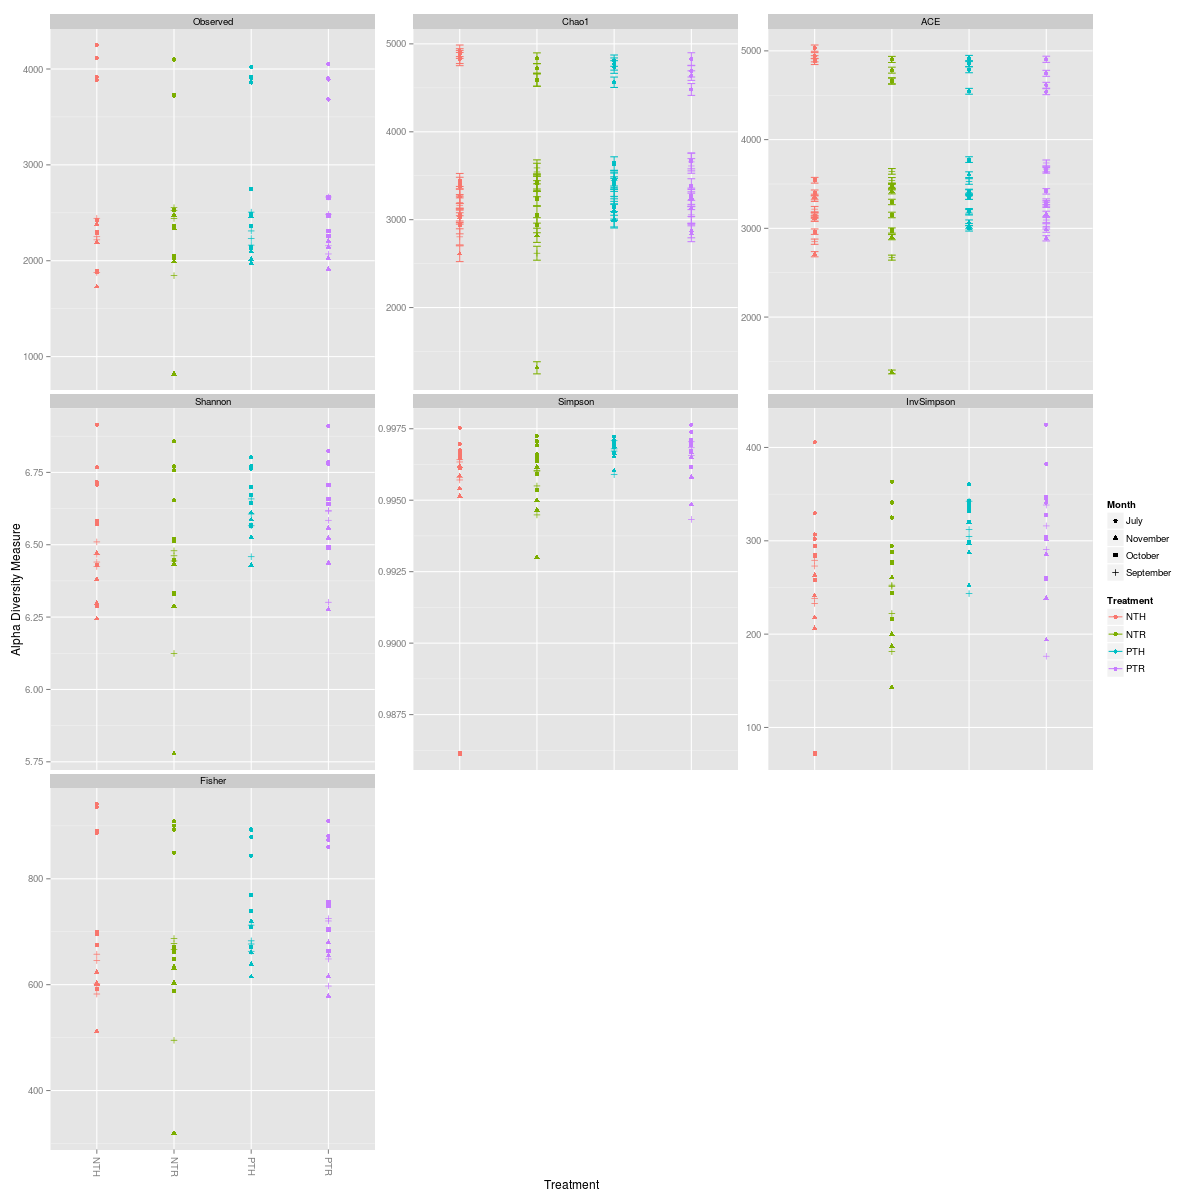

In [30]:
%%R -w 1200 -h 1200

p3 =plot_richness(physeq, x = "Treatment", color = "Treatment", shape =("Month"), title = NULL, 
              scales = "free_y", nrow = 3, shsi = NULL, measures = NULL)

p3

In [31]:
%%R
div$soil = physeq.md$Treatment
div$month = physeq.md$Month
div$rep = physeq.md$Replicate
div$till = physeq.md$Till
head(div)

     Observed    Chao1 se.chao1      ACE   se.ACE  Shannon   Simpson InvSimpson
NTR3     4102 4722.493 54.46698 4782.803 33.69499 6.857385 0.9972475   363.3089
NTH1     3918 4851.205 74.55890 4911.110 35.15840 6.707913 0.9967403   306.7760
NTH4     4116 4921.886 65.45514 5030.876 35.28904 6.717456 0.9969641   329.3942
PTH4     4021 4809.254 64.74548 4914.426 34.87013 6.763108 0.9970570   339.7919
PTR4     3891 4689.880 66.32850 4747.161 33.96613 6.778442 0.9970659   340.8167
NTR1     3721 4590.299 71.54223 4658.633 34.27441 6.653880 0.9966058   294.6234
       Fisher soil month rep till
NTR3 908.8331  NTR  July   3    N
NTH1 886.2474  NTH  July   1    N
NTH4 890.9174  NTH  July   4   N 
PTH4 893.3398  PTH  July   4    P
PTR4 881.0574  PTR  July   4    P
NTR1 849.3159  NTR  July   1    N


In [157]:
%%R
tbl.mean <- group_by(div,till) %.%
  summarise(
          count = n(),
          mean_Shannon = mean(Shannon),
          mean_Chao1 = mean(Chao1),
          stdev_Shannon = sd(Shannon, na.rm=TRUE), #/ sqrt(n())
          stdev_Chao1 = sd(Chao1, na.rm=TRUE), #/ sqrt(n())
          stderr_Shannon = sd(Shannon, na.rm=TRUE) / sqrt(count),
          stderr_Chao1 = sd(Chao1, na.rm=TRUE) / sqrt(count)
          )

In [158]:
%%R
tbl.mean

Source: local data frame [3 x 8]

  till count mean_Shannon mean_Chao1 stdev_Shannon stdev_Chao1 stderr_Shannon
1    N    24     5.968259   1680.755     0.1822585   233.23289     0.03720337
2    P    24     6.167831   1785.404     0.1185508   125.63044     0.02419907
3   NA     2     5.785449   1247.937     0.1073622    10.47204     0.07591652
Variables not shown: stderr_Chao1 (dbl)


In [163]:
%%R
head(div)

        Observed    Chao1 se.chao1      ACE   se.ACE  Shannon   Simpson
S.NTR.2     1347 1749.546 51.64352 1772.484 21.20025 6.017657 0.9932031
O.PTH.1     1433 1855.086 53.18937 1843.181 21.30411 6.290751 0.9957230
N.PTH.1     1223 1603.742 50.09166 1617.715 20.17616 6.119910 0.9944901
S.PTH.4     1313 1868.271 67.73277 1849.059 22.57988 6.236175 0.9954451
S.NTH.4     1116 1549.769 56.90228 1600.296 21.73004 6.054292 0.9944145
S.NTR.1     1500 1922.430 52.10796 1941.071 22.12283 6.055726 0.9939101
        InvSimpson   Fisher soil     month rep till
S.NTR.2   147.1254 384.4983  NTR September   2    N
O.PTH.1   233.8113 444.7355  PTH   October   1    P
N.PTH.1   181.4924 392.9742  PTH  November   1    P
S.PTH.4   219.5421 438.7192  PTH September   4    P
S.NTH.4   179.0345 370.3838  NTH September   4    N
S.NTR.1   164.2076 403.9055  NTR September   1    N


In [179]:
%%R
with(div, pairwise.t.test(Simpson, soil,
                 p.adjust.method="holm", paired=F))


	Pairwise comparisons using t tests with pooled SD 

data:  Simpson and soil 

    NTH  NTR  PAS  PTH 
NTR 1.00 -    -    -   
PAS 1.00 1.00 -    -   
PTH 0.12 0.13 1.00 -   
PTR 0.44 0.44 1.00 1.00

P value adjustment method: holm 


In [170]:
%%R
t.test(div$Simpson~div$till) 


	Welch Two Sample t-test

data:  div$Simpson by div$till
t = -3.2409, df = 30.294, p-value = 0.002893
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0033435236 -0.0007592121
sample estimates:
mean in group N mean in group P 
      0.9927944       0.9948458 



In [169]:
%%R
t.test(div$Chao1~div$till) 


	Welch Two Sample t-test

data:  div$Chao1 by div$till
t = -1.9352, df = 35.31, p-value = 0.061
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -214.39461    5.09584
sample estimates:
mean in group N mean in group P 
       1680.755        1785.404 



In [168]:
%%R
with(div, pairwise.t.test(Chao1, soil,
                 p.adjust.method="holm", paired=F))


	Pairwise comparisons using t tests with pooled SD 

data:  Chao1 and soil 

    NTH    NTR    PAS    PTH   
NTR 1.0000 -      -      -     
PAS 0.0348 0.0348 -      -     
PTH 0.7957 0.7957 0.0042 -     
PTR 0.9312 0.9312 0.0064 1.0000

P value adjustment method: holm 


In [ ]:
 J <- H/log(specnumber(BCI))

###Ordinate using weighted unifrac distnaces with NMDS.

Run 0 stress 0.1313669 
Run 1 stress 0.1316731 
... procrustes: rmse 0.04810475  max resid 0.2790751 
Run 2 stress 0.1316733 
... procrustes: rmse 0.04796766  max resid 0.2785359 
Run 3 stress 0.152986 
Run 4 stress 0.132193 
Run 5 stress 0.1530357 
Run 6 stress 0.1513561 
Run 7 stress 0.1316724 
... procrustes: rmse 0.04808607  max resid 0.2789861 
Run 8 stress 0.1313732 
... procrustes: rmse 0.001086942  max resid 0.007488614 
*** Solution reached


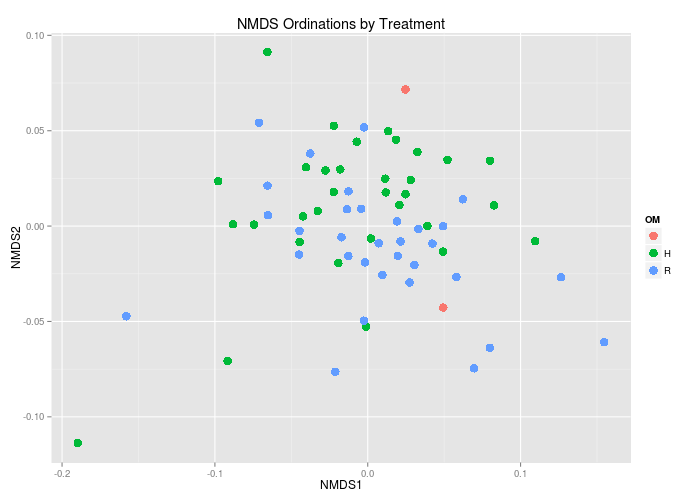

In [33]:
%%R -w 700 -h 500
wunif.dist.nopas = distance(physeq.thresh_nopas
nmds = ordinate(physeq.thresh_nopas, 
                method = "NMDS", 
                distance = wunif.dist)#.nopas)
p.nmds = plot_ordination(physeq.thresh, nmds, justDF = TRUE)
#print(p)

levels(p.nmds$Month)
p.nmds$Month <- factor(p.nmds$Month, levels = c("July", "September", "October", "November"))
levels(p.nmds$Month)

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmds1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Treatment), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Treatment") + scale_shape_manual(values = c(15,16,17,18))

print(p.nmds1)

In [44]:
%%R
ggsave(filename = "figs/Treatment_ord.png", plot = p.nmds1, width =7, height =5)

In [28]:
%%R -w 700 -h 500
nmds = ordinate(physeq.thresh.nopas, 
                method = "NMDS", 
                distance = wunif.dist)
p.nmds = plot_ordination(physeq.thresh, nmds, justDF = TRUE)
#print(p)

levels(p.nmds$Month)
p.nmds$Month <- factor(p.nmds$Month, levels = c("July", "September", "October", "November"))
levels(p.nmds$Month)

asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmdsmonth = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Month), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Month") + scale_shape_manual(values = c(15,16,17,18))

print(p.nmdsmonth)

Error in inherits(physeq, "formula") : 
  object 'physeq.thresh.nopas' not found


In [50]:
%%R
ggsave(filename = "figs/Month_ord.png", plot = p.nmdsmonth, width =7, height =5)

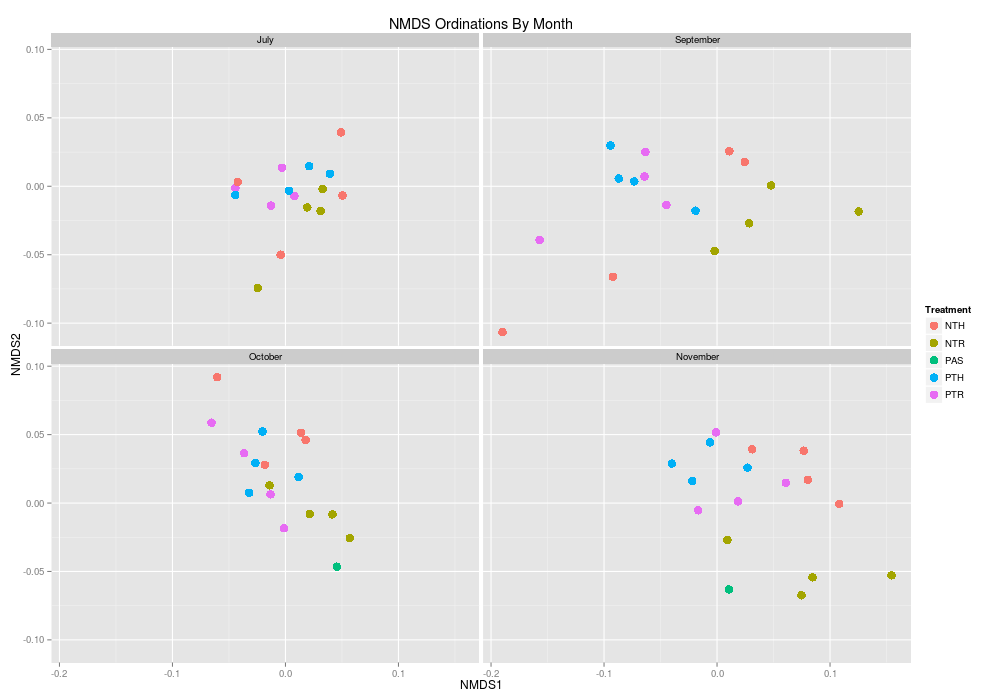

In [22]:
%%R -w 1000 -h 700


asNumeric = function(x) { as.numeric(as.character(x)) }

p.nmds1 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Treatment), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        facet_wrap(~Month) + labs(title="NMDS Ordinations By Month")

print(p.nmds1)

In [46]:
%%R
head(p.nmds)

           NMDS1        NMDS2 Sample     i1_r     i2_f Treatment Month
NTR3 -0.01937525 -0.078310318   NTR3 cgagcgac agagtcac       NTR  July
NTH1  0.05109937 -0.016022202   NTH1 actacgac ctactata       NTH  July
NTH4  0.05326626  0.037857773   NTH4 actacgac tacgagac       NTH  July
PTH4  0.04079056  0.002244115   PTH4 actacgac gtcagata       PTH  July
PTR4 -0.01171980 -0.016164961   PTR4 cgagcgac gtcagata       PTR  July
NTR1  0.03200247 -0.021430387   NTR1 cgagcgac ctactata       NTR  July
     Replicate Till OM
NTR3         3    N  R
NTH1         1    N  H
NTH4         4    N  H
PTH4         4    P  H
PTR4         4    P  R
NTR1         1    N  R


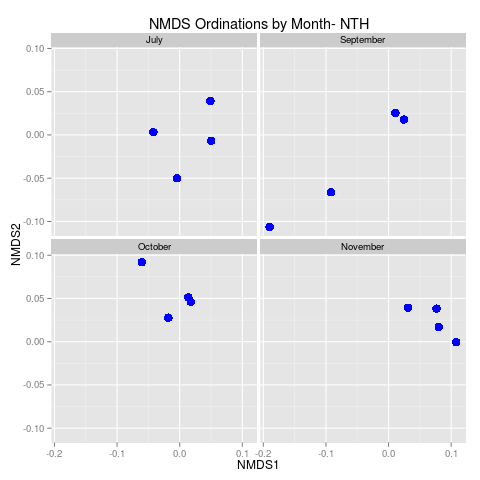

In [23]:
%%R
NTH = filter(p.nmds, Treatment == "NTH")

p.nmds1 = ggplot(NTH, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(color = "blue", size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        facet_wrap(~Month) + labs(title="NMDS Ordinations by Month- NTH")

print(p.nmds1)

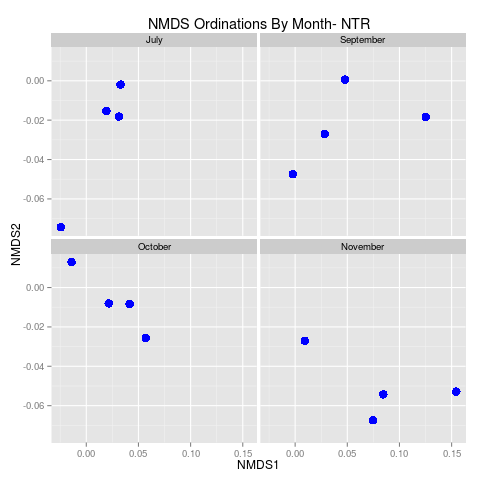

In [24]:
%%R
NTR = filter(p.nmds, Treatment == "NTR")

p.nmds1 = ggplot(NTR, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(color = "blue", size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        facet_wrap(~Month) + labs(title="NMDS Ordinations By Month- NTR")

print(p.nmds1)

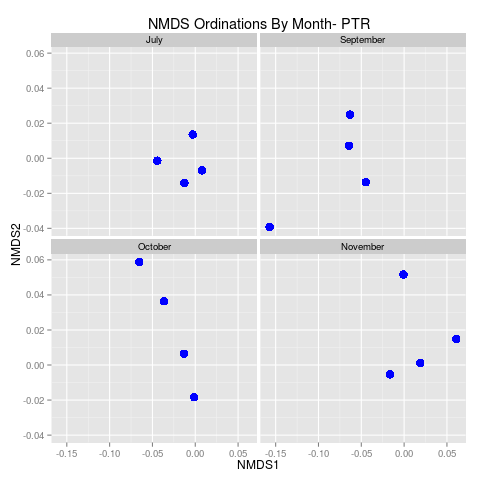

In [25]:
%%R
PTR = filter(p.nmds, Treatment == "PTR")

p.nmds1 = ggplot(PTR, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(color = "blue", size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        facet_wrap(~Month) + labs(title="NMDS Ordinations By Month- PTR")

print(p.nmds1)

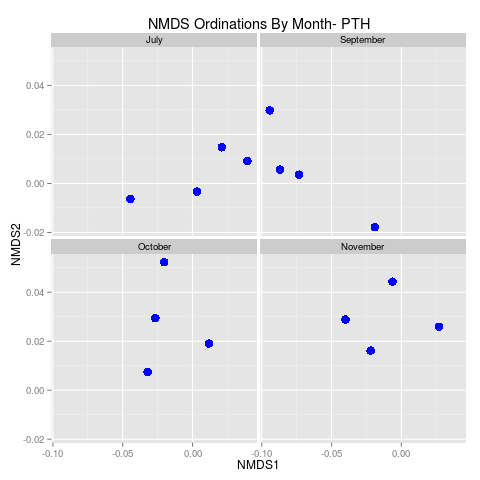

In [26]:
%%R
PTH = filter(p.nmds, Treatment == "PTH")

p.nmds1 = ggplot(PTH, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(color = "blue", size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        facet_wrap(~Month) + labs(title="NMDS Ordinations By Month- PTH")

print(p.nmds1)

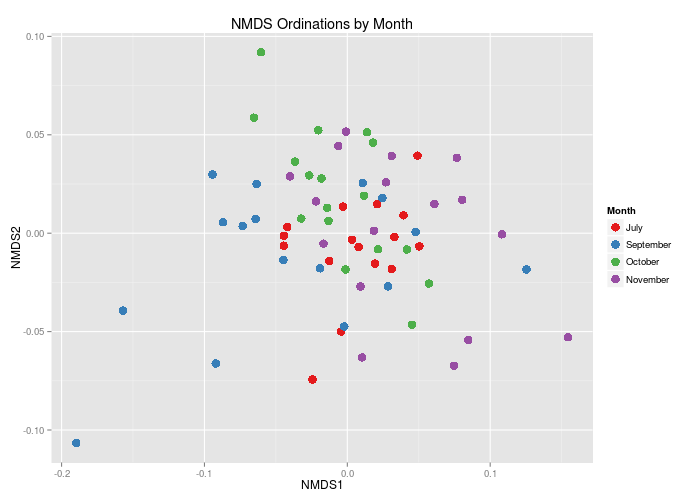

In [27]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Month), size = 4)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Month")


p.nmds3 = p.nmds3 + scale_color_brewer(palette="Set1")

print(p.nmds3)




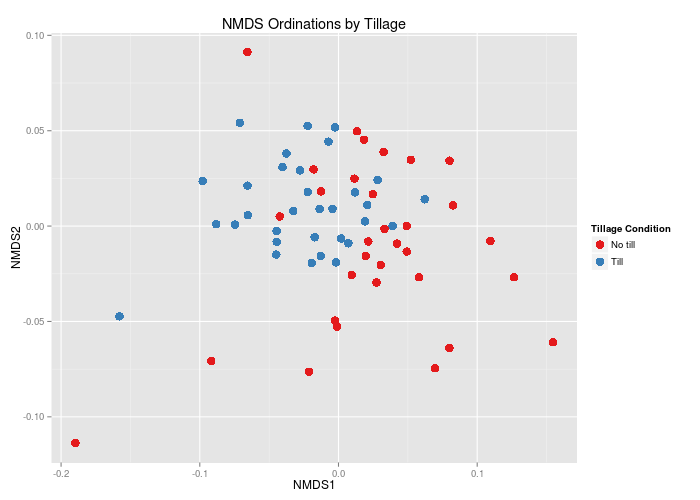

In [38]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = Till), size = 4)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by Tillage")


p.nmds3 = p.nmds3 + scale_color_brewer(palette = "Set1",
                      "Tillage Condition", 
                      labels=c("No till", "Till"))
        
 #scale_color_brewer(palette="Set1") + 

print(p.nmds3)



In [40]:
%%R
ggsave(filename = "figs/Till_ord.png", plot = p.nmds3, width =7, height =5)

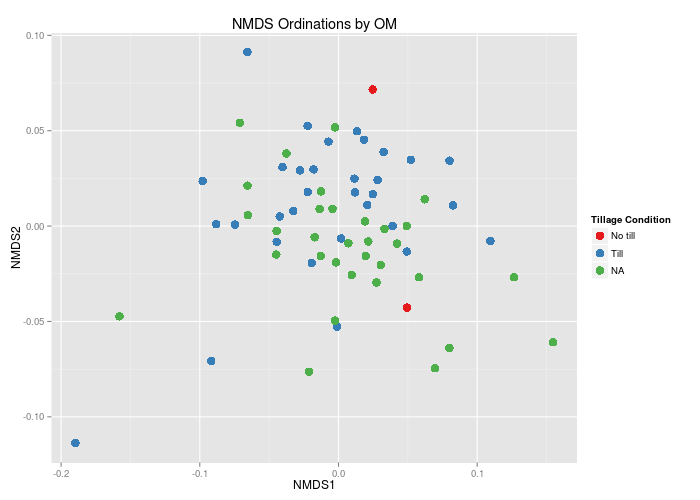

In [69]:
%%R -w 700 -h 500
p.nmds3 = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2)) +  
        geom_point(aes(color = OM), size = 4)  +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))+
        labs(title="NMDS Ordinations by OM")


p.nmds3 = p.nmds3 + scale_color_brewer(palette = "Set1",
                      "Tillage Condition", 
                      labels=c("No till", "Till"))
        
 #scale_color_brewer(palette="Set1") + 

print(p.nmds3)




In [70]:
%%R
ggsave(filename = "figs/OM_ord.png", plot = p.nmds4, width =7, height =5)

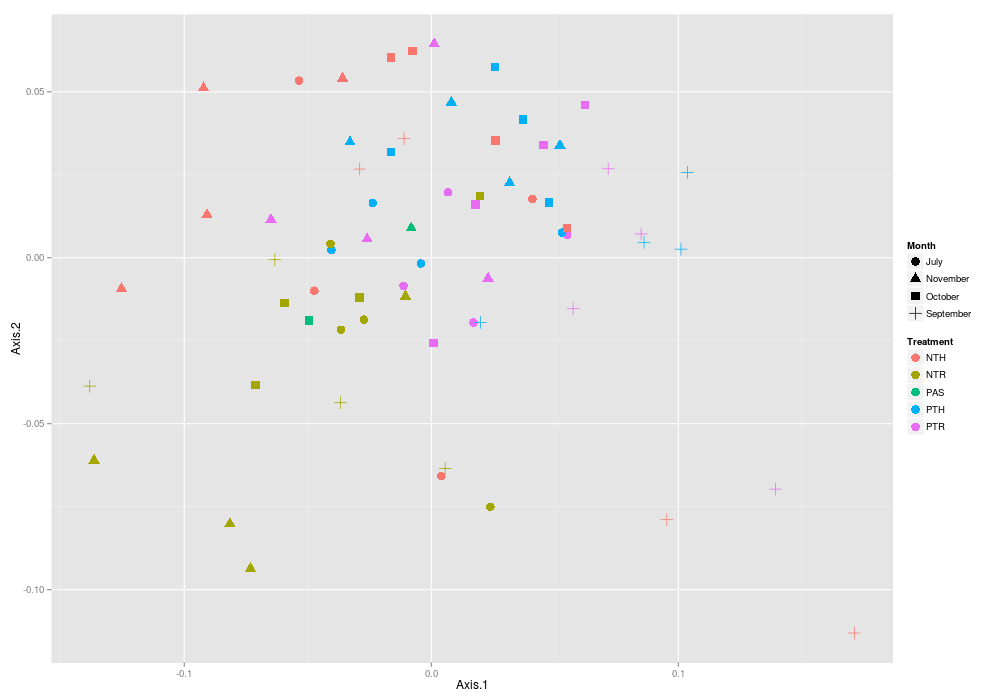

In [33]:
%%R -w 1000 -h 700
pcoa = ordinate(physeq.thresh, 
                method = "PCoA", 
                distance = wunif.dist)
p.pcoa = plot_ordination(physeq.thresh, pcoa, justDF = TRUE)
#print(p)

asNumeric = function(x) { as.numeric(as.character(x)) }

p.pcoa1 = ggplot(p.pcoa, aes(x = Axis.1, y = Axis.2)) +  
        geom_point(aes(color = Treatment, shape = Month), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))

print(p.pcoa1)

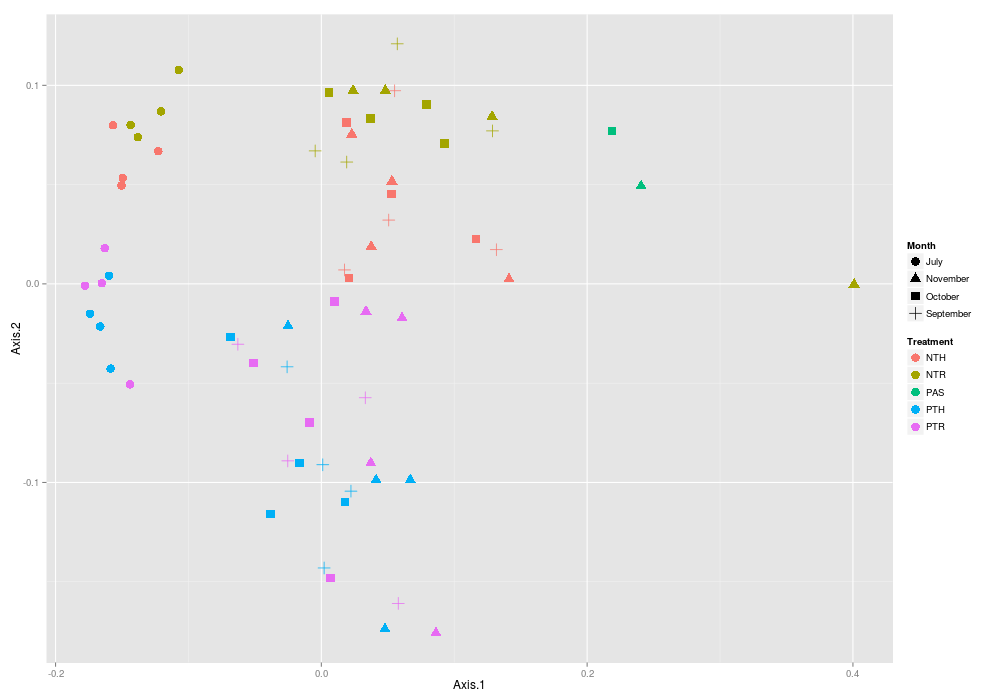

In [34]:
%%R -w 1000 -h 700
pcoa = ordinate(physeq.thresh, 
                method = "PCoA", 
                distance = uunif.dist)
p.pcoa = plot_ordination(physeq.thresh, pcoa, justDF = TRUE)
#print(p)

asNumeric = function(x) { as.numeric(as.character(x)) }

p.pcoa1 = ggplot(p.pcoa, aes(x = Axis.1, y = Axis.2)) +  
        geom_point(aes(color = Treatment, shape = Month), size = 4) +
        guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6)))

print(p.pcoa1)

In [35]:
%%R -w 1000 -h 350
pdf("figs/full_ordination_Chazy_SON.pdf", width = 6, height = 5)
grid.arrange(p.nmds1, ncol= 1)
dev.off()

png 
  2 


In [14]:
FileLink("figs/full_ordination_Chazy_SON.pdf")

/home/chantal/Chazy/figs/full_ordination_Chazy.pdf

# Checking different distance matrices

In [36]:
%%R
dist_methods = unlist(distance("list"))
dist_methods = dist_methods[-(1:2)]
dist_methods = dist_methods[-which(dist_methods == "ANY")]
dist_methods = dist_methods[-which(dist_methods == "morisita")]
dist_methods = dist_methods[-which(dist_methods == "mountford")]
dist_methods = c(dist_methods, c=c("wunif","uwunif"))
print(dist_methods)

       DPCoA          JSD     vegdist1     vegdist2     vegdist3     vegdist4 
     "dpcoa"        "jsd"  "manhattan"  "euclidean"   "canberra"       "bray" 
    vegdist5     vegdist6     vegdist7     vegdist8    vegdist10    vegdist12 
"kulczynski"    "jaccard"      "gower"   "altGower"       "horn"       "raup" 
   vegdist13    vegdist14    vegdist15   betadiver1   betadiver2   betadiver3 
  "binomial"       "chao"        "cao"          "w"         "-1"          "c" 
  betadiver4   betadiver5   betadiver6   betadiver7   betadiver8   betadiver9 
        "wb"          "r"          "I"          "e"          "t"         "me" 
 betadiver10  betadiver11  betadiver12  betadiver13  betadiver14  betadiver15 
         "j"        "sor"          "m"         "-2"         "co"         "cc" 
 betadiver16  betadiver17  betadiver18  betadiver19  betadiver20  betadiver21 
         "g"         "-3"          "l"         "19"         "hk"        "rlb" 
 betadiver22  betadiver23  betadiver24        dist1 

In [38]:
%%R
dlist.nmds = vector("list", length(dist_methods))
dlist.mds = vector("list", length(dist_methods))
names(dlist.nmds) = dist_methods
names(dlist.mds) = dist_methods
t = physeq.thresh
for (i in dist_methods) {
    # Calculate distance matrix
    if ( i == "wunif" ) {
            registerDoParallel(cores=30)
            iDist <- UniFrac(t, 
                             weighted = TRUE, 
                             fast = TRUE, 
                             normalized = FALSE, 
                             parallel = TRUE)
        } else if ( i == "uwunif" ) {
            registerDoParallel(cores=30)
            iDist <- UniFrac(t, 
                             weighted = FALSE, 
                             fast = TRUE, 
                             normalized = FALSE, 
                             parallel = TRUE)
        } else 
            iDist <- distance(t, method = i)
    
    # Calculate ordination
    iNMDS <- ordinate(t, "NMDS", distance = iDist)
    iMDS <- ordinate(t, "MDS", distance = iDist)

    df.nmds <- NULL
    df.mds <- NULL
    df.nmds <- plot_ordination(t, iNMDS, justDF = TRUE)
    df.mds <- plot_ordination(t, iMDS, justDF = TRUE)  
    dlist.nmds[[i]] = df.nmds
    dlist.mds[[i]] = df.mds
}


Run 0 stress 0.06933658 
Run 1 stress 0.06963774 
... procrustes: rmse 0.003717154  max resid 0.01808164 
Run 2 stress 0.07292109 
Run 3 stress 0.07650397 
Run 4 stress 0.07638267 
Run 5 stress 0.08433503 
Run 6 stress 0.06933306 
... New best solution
... procrustes: rmse 0.001183985  max resid 0.00570549 
*** Solution reached

Run 0 stress 0.1373399 
Run 1 stress 0.1402371 
Run 2 stress 0.1373403 
... procrustes: rmse 8.190485e-05  max resid 0.0003309276 
*** Solution reached

Run 0 stress 0.137466 
Run 1 stress 0.1374495 
... New best solution
... procrustes: rmse 0.01405926  max resid 0.07489693 
Run 2 stress 0.1374494 
... New best solution
... procrustes: rmse 6.191434e-05  max resid 0.0002609282 
*** Solution reached

Run 0 stress 0.1285063 
Run 1 stress 0.1387776 
Run 2 stress 0.1287826 
... procrustes: rmse 0.05485054  max resid 0.3522245 
Run 3 stress 0.1309867 
Run 4 stress 0.1308419 
Run 5 stress 0.1285007 
... New best solution
... procrustes: rmse 0.0008544411  max resid 

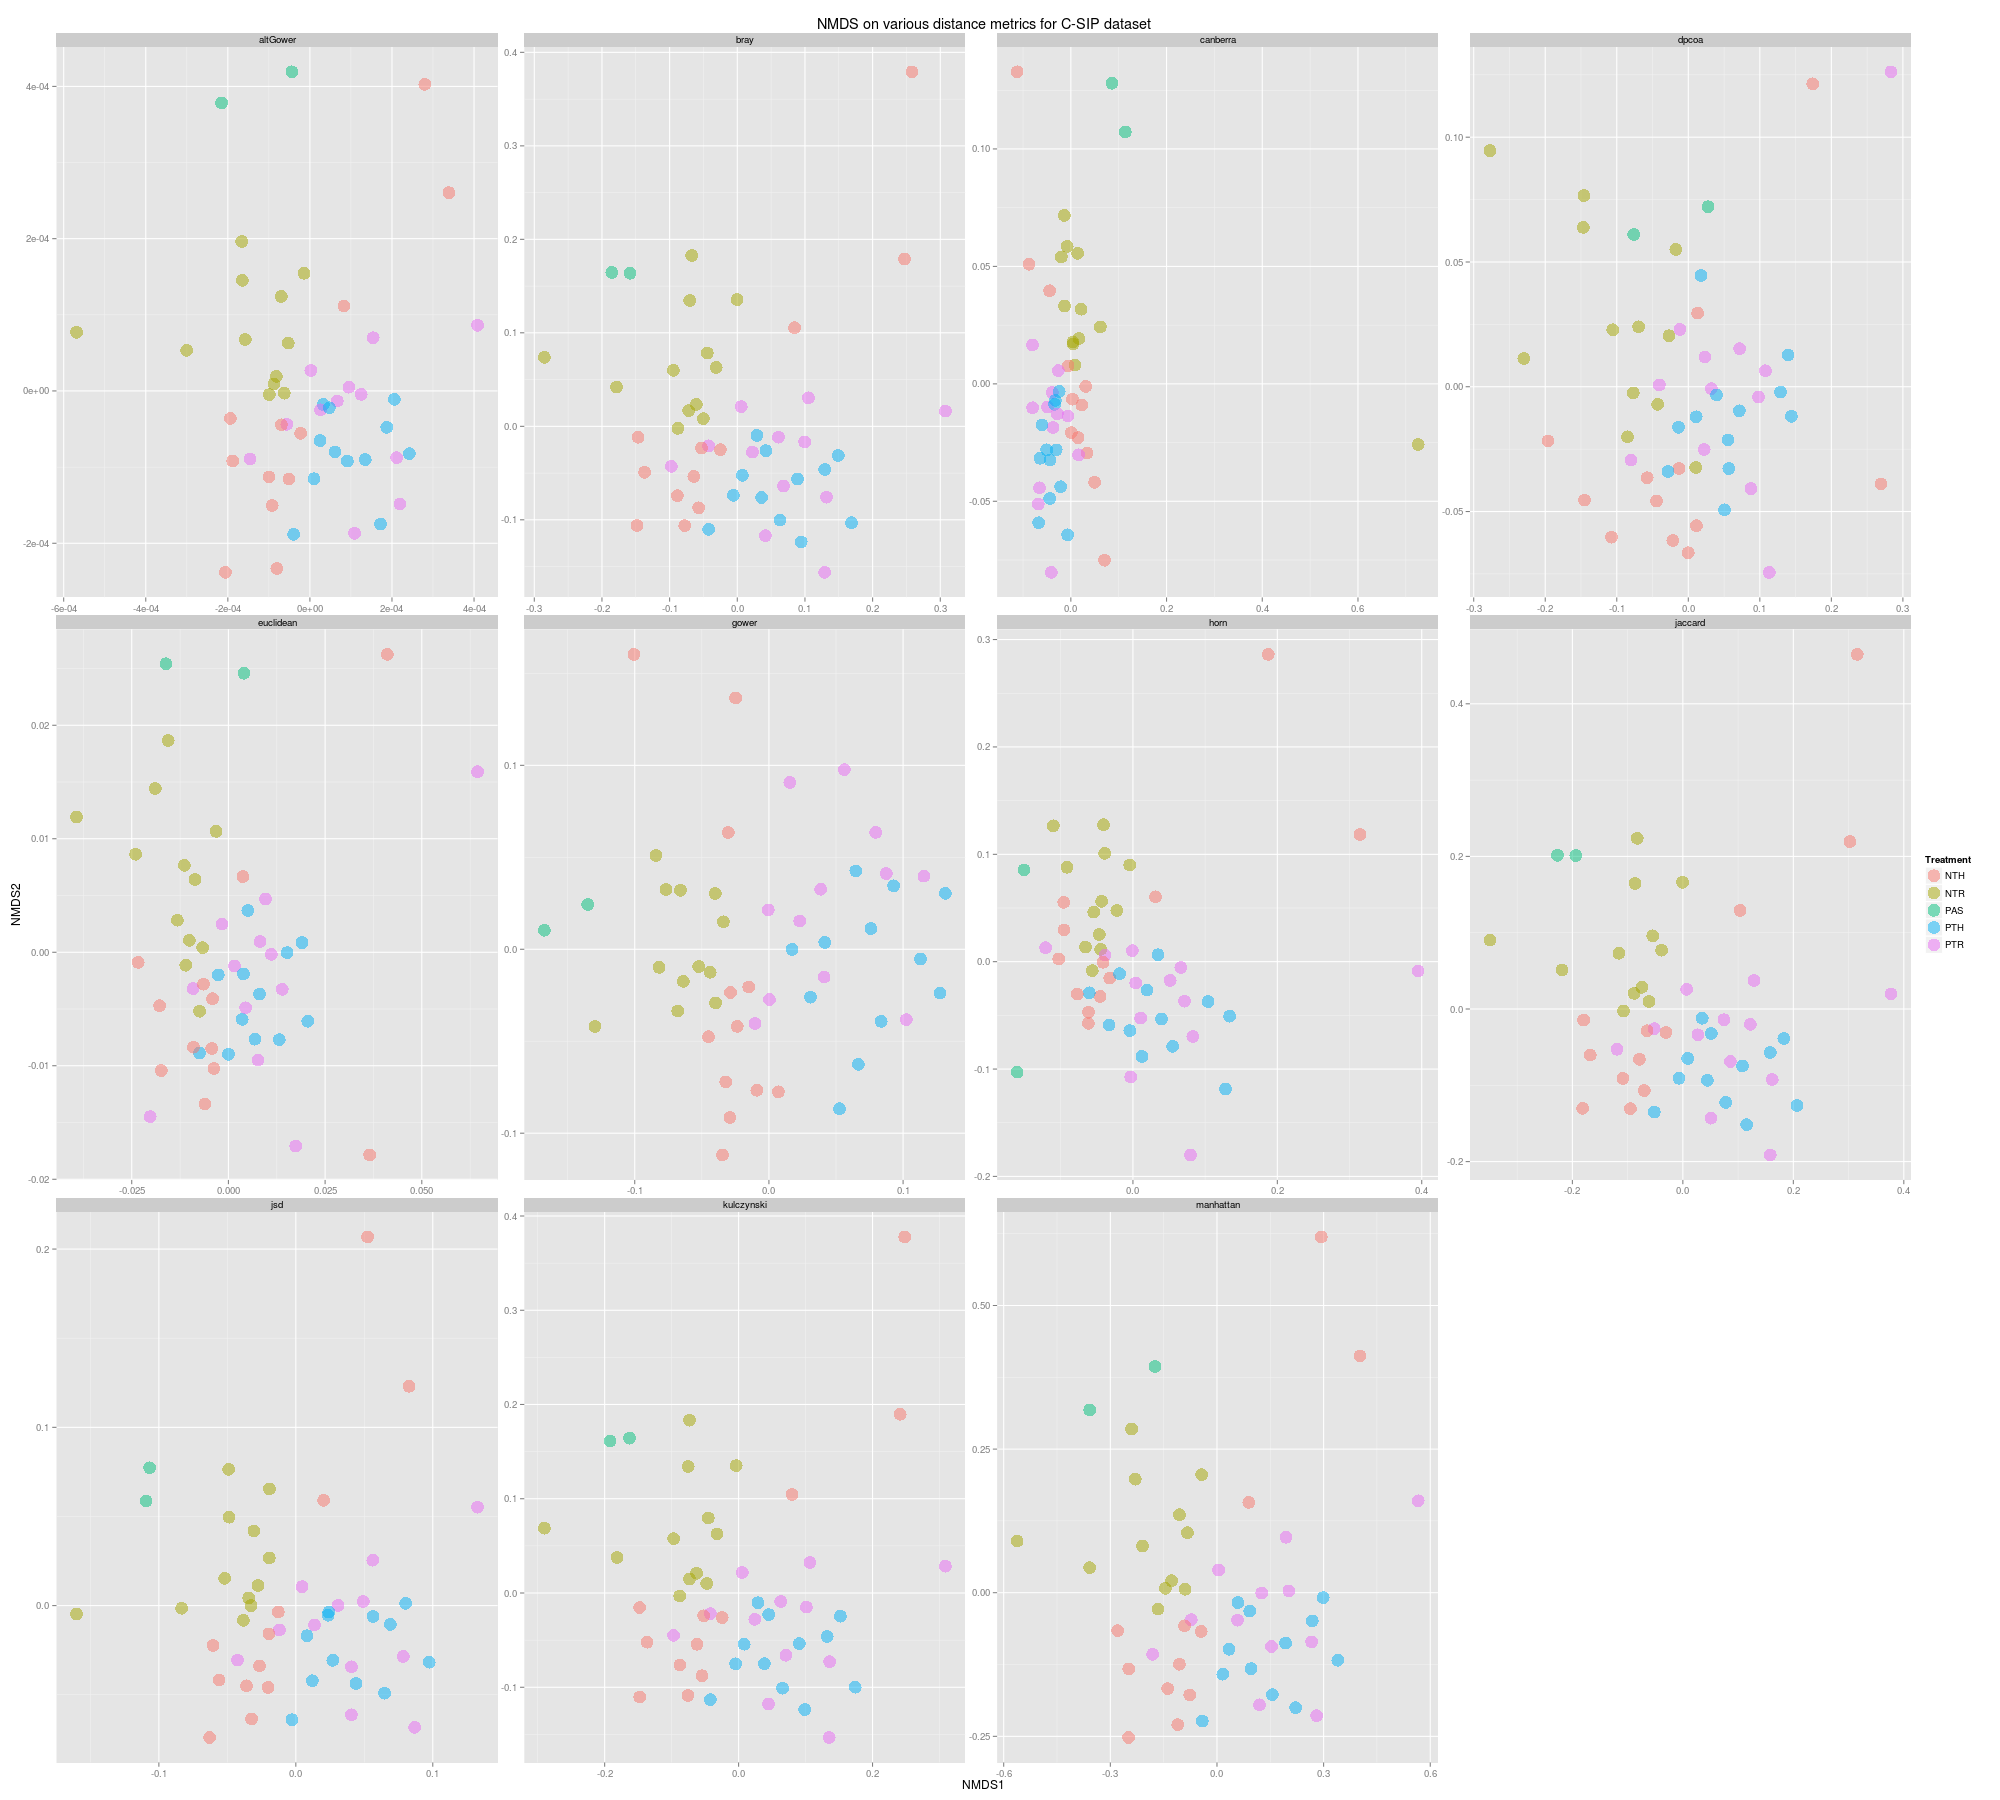

In [39]:
%%R -h 1800 -w 2000
df.nmds.all = ldply(dlist.nmds, function(x) x)
names(df.nmds.all)[1] <- "distance"
p = ggplot(df.nmds.all, aes(NMDS1, NMDS2, color = Treatment))
#p = p + scale_area(range = c(1,5))
p = p + geom_point(alpha = 0.5, size = 6)
p = p + facet_wrap(~distance, scales = "free")
p = p + ggtitle("NMDS on various distance metrics for C-SIP dataset")
print(p)

In [31]:
FileLink("figs/dragonfly_inset_facet_grid.pdf")

/home/chantal/RNASIP/figs/dragonfly_inset_facet_grid.pdf

In [40]:
%%R
site.scores = p.nmds[,c(1,2)]
dummy.treatment = model.matrix( ~ Treatment - 1, data = p.nmds)[,2]
e = envfit(site.scores, dummy.treatment)
#x.component = e$vectors$arrows[1,"Axis.1"]
#y.component = e$vectors$arrows[1,"Axis.2"]

In [41]:
%%R
print(head(e))

$vectors
        NMDS1    NMDS2     r2 Pr(>r)    
[1,] -0.54438  0.83884 0.3775  0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
P values based on 999 permutations.

$factors
NULL

$na.action
function (object, ...) 
UseMethod("na.action")
<bytecode: 0x4db54e8>
<environment: namespace:stats>



In [43]:
%%R
if( setequal(row.names(p.nmds), row.names(t(otu_table(physeq.thresh)))) ){
    w = wascores(p.nmds[,c(1,2)],t(otu_table(physeq.thresh)),expand=TRUE)
} else {
    print("Indices don't match")
    print(setdiff(row.names(m), row.names(t(otu_table(physeq.thresh)))))
}                                    
otu.scores = data.frame(w)

In [44]:
%%R
supp = tax_table(physeq.thresh)
if( setequal(row.names(otu.scores), row.names(supp)) ){
    otu.scores.wtax = data.frame(otu.scores, supp)
} else {
    print("Indices not the same.")
    print(setdiff(row.names(w.df), row.names(supp)))
}

NULL


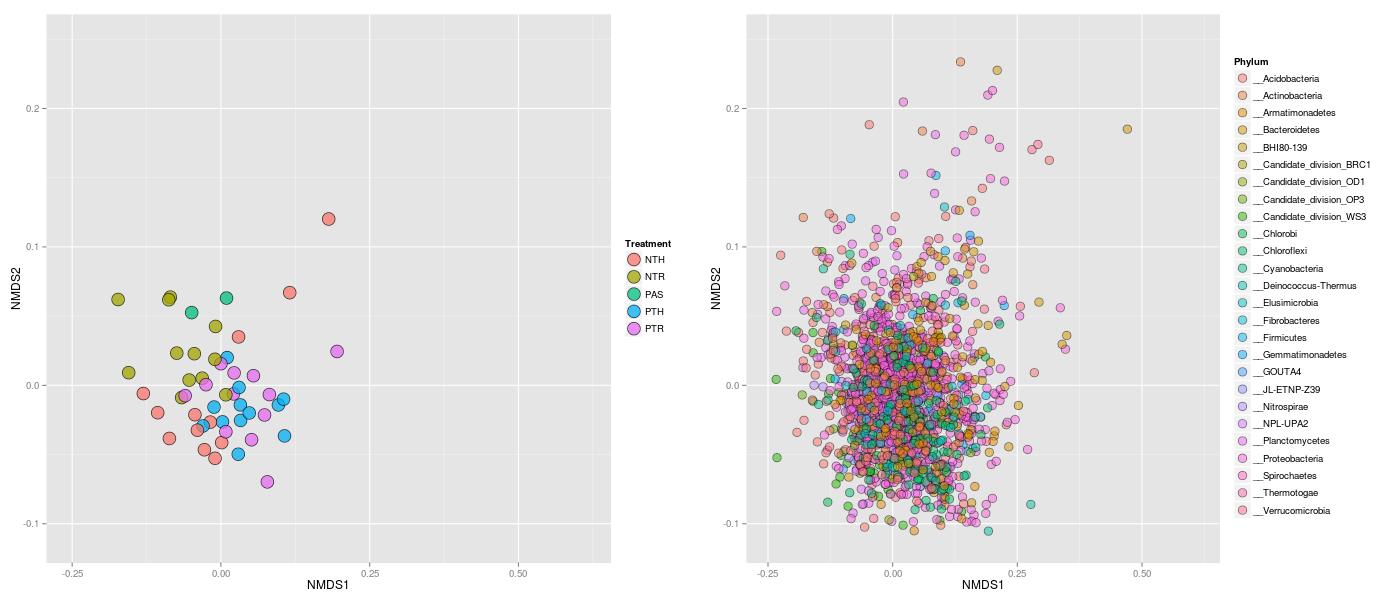

In [45]:
%%R -w 1400 -h 600
p.sites = ggplot(p.nmds, aes(x = NMDS1, y = NMDS2))
p.sites = p.sites + geom_point(aes(fill = Treatment), pch = 21, alpha = 0.75, size = 6) 
#p.sites = p.sites + scale_area(range = c(0,4))
p.sites = p.sites + ylim(c(-0.11, 0.25)) + xlim(c(-0.25, 0.6125))
#p.sites = p.sites + geom_segment(aes(x = 0, y = 0))#, 
                                     #xend = x.component/5, 
                                     #yend = y.component/5), 
                                 #arrow = arrow())

p.otus = ggplot(otu.scores.wtax, aes(x = NMDS1, y = NMDS2))
p.otus = p.otus + geom_point(aes(fill = Rank2), pch=21, alpha = 0.5, size = 4)
p.otus = p.otus + labs(shape = "OTU", fill = "Phylum")
p.otus = p.otus + ylim(c(-0.11, 0.25)) + xlim(c(-0.25, 0.6125))

p.biplot = grid.arrange(p.sites, p.otus, ncol = 2)
print(p.biplot)

In [46]:
%%R
otu.scores.sorted <- otu.scores.wtax[order(otu.scores.wtax$NMDS2, decreasing = TRUE), ]
print(otu.scores.sorted[1:20,1:5])

               NMDS1     NMDS2    Rank1             Rank2
OTU.2775  0.35994121 0.3080254 Bacteria  __Planctomycetes
OTU.264   0.31134200 0.2995292 Bacteria  __Proteobacteria
OTU.518   0.35499342 0.2942920 Bacteria  __Proteobacteria
OTU.1252  0.24965584 0.2548632 Bacteria  __Actinobacteria
OTU.1211  0.13612992 0.2336888 Bacteria  __Actinobacteria
OTU.456   0.20967757 0.2275943 Bacteria   __Bacteroidetes
OTU.153   0.20026809 0.2129773 Bacteria  __Proteobacteria
OTU.392   0.19083886 0.2097227 Bacteria  __Proteobacteria
OTU.369   0.02149474 0.2046898 Bacteria  __Proteobacteria
OTU.500  -0.04694715 0.1882972 Bacteria   __Acidobacteria
OTU.3086  0.47069587 0.1850507 Bacteria   __Bacteroidetes
OTU.872   0.16072406 0.1840854 Bacteria   __Acidobacteria
OTU.1765  0.05974535 0.1837154 Bacteria  __Actinobacteria
OTU.997   0.08569947 0.1811379 Bacteria  __Planctomycetes
OTU.379   0.14326127 0.1806574 Bacteria  __Proteobacteria
OTU.1443  0.19404371 0.1778753 Bacteria    __Spirochaetes
OTU.1864  0.29

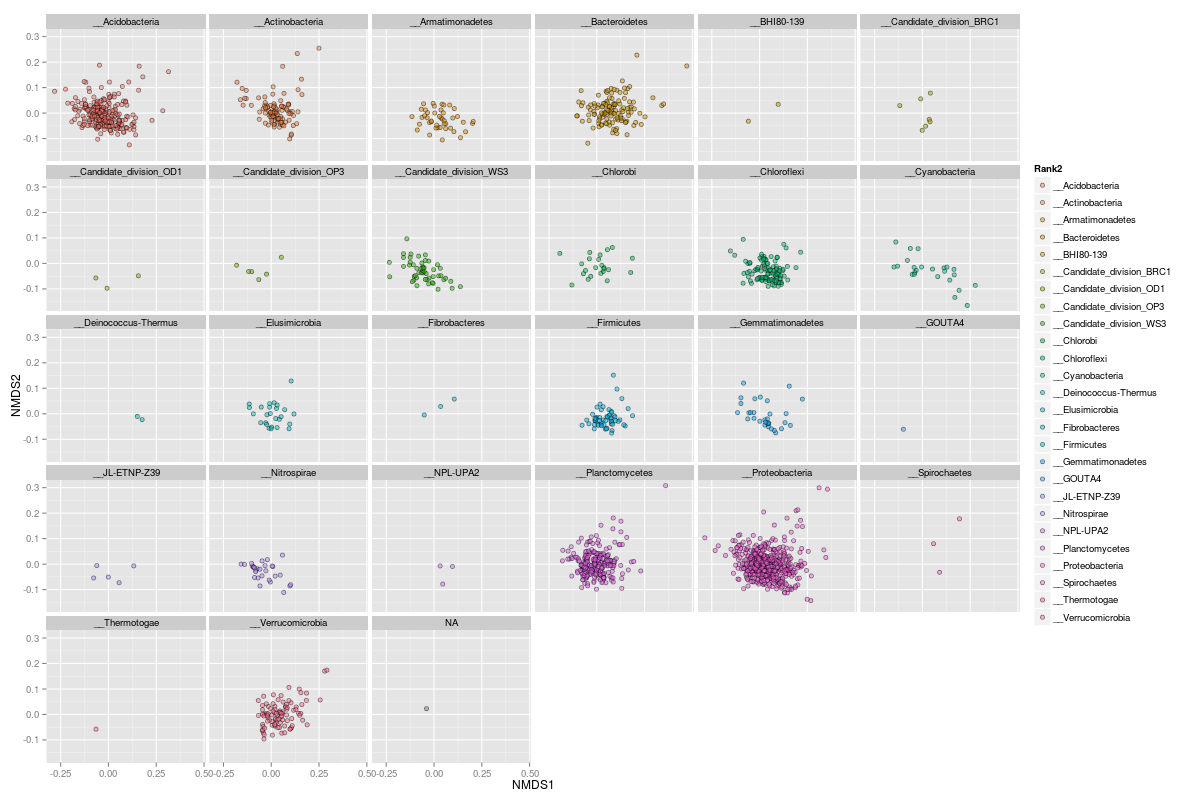

In [47]:
%%R -w 1200 -h 800

p.otus = ggplot(otu.scores.wtax, aes(x = NMDS1, y = NMDS2))
p.otus = p.otus + geom_point(aes(fill = Rank2), pch=21, size=2, alpha=0.5)
p.otus = p.otus + facet_wrap(~Rank2)

print(p.otus)